In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/3/run_2025-03-10_11-21-09/run_4b2f8_00009_9_config=n_stores_lost_demand_fixed,early_stop_check_epochs=10,learning_rate=0.0100,master=512,samples=2,stop_if_n_2025-03-10_11-21-09: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/3/run_2025-03-10_11-21-09/run_4b2f8_00000_0_config=n_stores_lost_demand_fixed,early_stop_check_epochs=10,learning_rate=0.0100,master=512,samples=1,stop_if_n_2025-03-10_11-21-09: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/20/run_2025-03-10_11-22-25/run_7890b_00063_63_config=n_stores_lost_demand_fixed,early_stop_check_epochs=10,learning_rate=0.0100,master=512,samples=2,stop_if__2025-03-10_11-22-26: All rows contained NaN

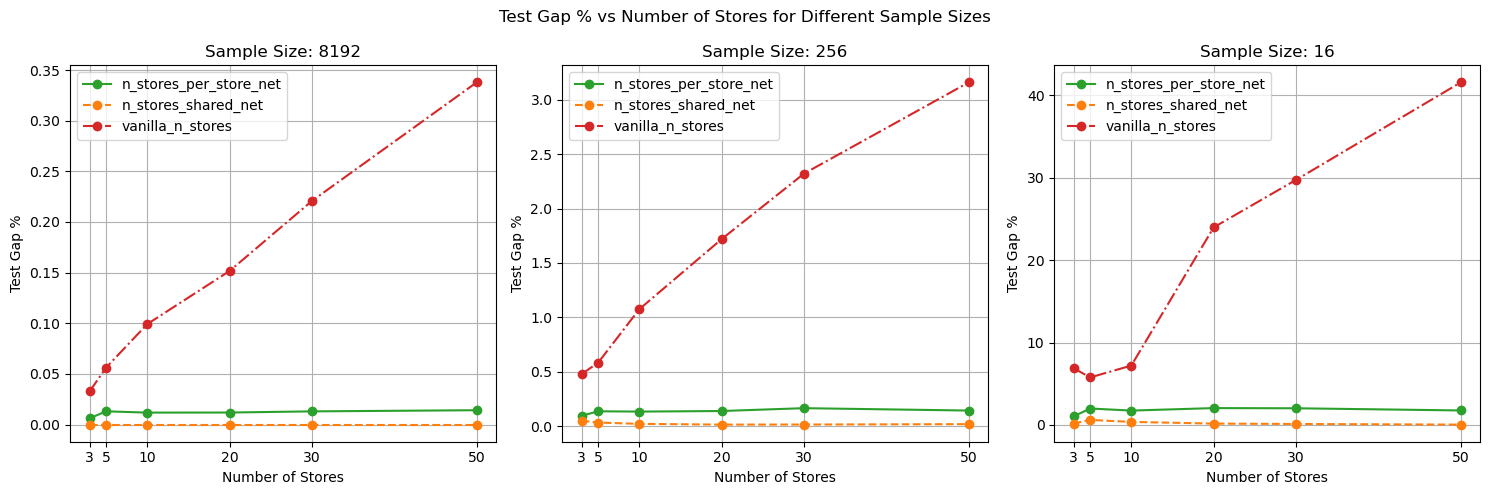

In [3]:
# Define color scheme for architecture types
color_scheme = {
    "n_stores_per_store_net": "#2ca02c",  # Green
    "n_stores_shared_net": "#ff7f0e",  # Orange
    "vanilla_n_stores": "#d62728"  # Red
}

linestyle_scheme = {
    "n_stores_per_store_net": "-",  # Solid
    "n_stores_shared_net": "--",  # Dashed 
    "vanilla_n_stores": "-."  # Dash-dot
}

testset_name = "models_overfit_in_many_stores_test_fixed"
n_stores_list = [3, 5, 10, 20, 30, 50]

vanilla_n_stores_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores/{n}'
    for n in n_stores_list
}

n_stores_shared_net_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net/{n}'
    for n in n_stores_list
}

n_stores_per_store_net_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_per_store_net/{n}'
    for n in n_stores_list
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Vanilla N Stores
df_vanilla = results_interpretor.make_table(vanilla_n_stores_paths,
    {"train_dev_sample_and_batch_size": [8192, 256, 16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "vanilla_n_stores")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_stores")

# N Stores Shared Net
df_shared = results_interpretor.make_table(n_stores_shared_net_paths,
    {"train_dev_sample_and_batch_size": [8192, 256, 16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_shared.insert(2, 'Architecture Class', "n_stores_shared_net")
df_shared.insert(1, 'hyperparam_name', "n_stores_shared_net")

# N Stores Per Store Net
df_per_store = results_interpretor.make_table(n_stores_per_store_net_paths,
    {"train_dev_sample_and_batch_size": [8192, 256, 16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_per_store.insert(2, 'Architecture Class', "n_stores_per_store_net")
df_per_store.insert(1, 'hyperparam_name', "n_stores_per_store_net")

# Combine dataframes
df = pd.concat([
    df_vanilla,
    df_shared, 
    df_per_store
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create plot grid for different sample sizes
sample_sizes = [8192, 256, 16]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Test Gap % vs Number of Stores for Different Sample Sizes')

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle=linestyle_scheme[column])
    
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Test Gap %')
    ax.set_title(f'Sample Size: {sample_size}')
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    ax.legend()  # Show legend on each subplot

plt.tight_layout()
plt.show()

Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/3/run_2025-03-10_11-21-09/run_4b2f8_00009_9_config=n_stores_lost_demand_fixed,early_stop_check_epochs=10,learning_rate=0.0100,master=512,samples=2,stop_if_n_2025-03-10_11-21-09: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/3/run_2025-03-10_11-21-09/run_4b2f8_00000_0_config=n_stores_lost_demand_fixed,early_stop_check_epochs=10,learning_rate=0.0100,master=512,samples=1,stop_if_n_2025-03-10_11-21-09: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/models_overfit_in_many_stores_test_fixed/vanilla_n_stores/20/run_2025-03-10_11-22-25/run_7890b_00063_63_config=n_stores_lost_demand_fixed,early_stop_check_epochs=10,learning_rate=0.0100,master=512,samples=2,stop_if__2025-03-10_11-22-26: All rows contained NaN

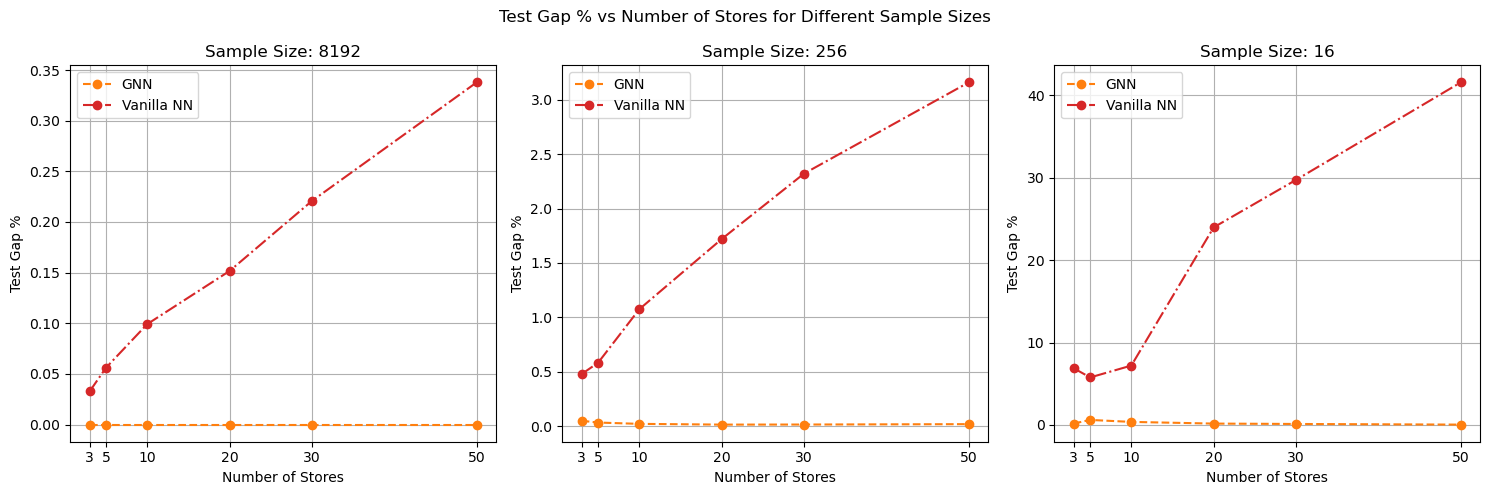

In [3]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#ff7f0e",  # Orange
    "Vanilla NN": "#d62728"  # Red
}

linestyle_scheme = {
    "GNN": "--",  # Dashed
    "Vanilla NN": "-."  # Dash-dot
}

testset_name = "models_overfit_in_many_stores_test_fixed"
n_stores_list = [3, 5, 10, 20, 30, 50]

vanilla_n_stores_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores/{n}'
    for n in n_stores_list
}

n_stores_shared_net_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net/{n}'
    for n in n_stores_list
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Vanilla N Stores
df_vanilla = results_interpretor.make_table(vanilla_n_stores_paths,
    {"train_dev_sample_and_batch_size": [8192, 256, 16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_stores")

# N Stores Shared Net
df_shared = results_interpretor.make_table(n_stores_shared_net_paths,
    {"train_dev_sample_and_batch_size": [8192, 256, 16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_shared.insert(2, 'Architecture Class', "GNN")
df_shared.insert(1, 'hyperparam_name', "n_stores_shared_net")

# Combine dataframes
df = pd.concat([
    df_vanilla,
    df_shared
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create plot grid for different sample sizes
sample_sizes = [8192, 256, 16]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Test Gap % vs Number of Stores for Different Sample Sizes')

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle=linestyle_scheme[column])
    
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Test Gap %')
    ax.set_title(f'Sample Size: {sample_size}')
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    ax.legend()  # Show legend on each subplot

plt.tight_layout()
plt.show()